In [1]:
## LOAD MODULES ##
# Third Party
import sys
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
import psyplot.project as psy
import pandas as pd
import xarray
from netCDF4 import Dataset,date2num
import xarray as xr
from matplotlib import cm
import datetime as dt
from iconarray.plot import formatoptions # import plotting formatoptions (for use with psyplot)
import iconarray as iconvis # import self-written modules from iconarray
import pickle
from matplotlib.lines import Line2D
pd.plotting.deregister_matplotlib_converters()

# First Party
sys.path.append('../utilities_tlezuo/')
# from timefunctions import *
import varfunctions as vf
import locfunctions as lf
import get_stations_timeseries as gs

###############################################################################################
# define class of pc_dict
class Point_coordinates:
    def __init__(self, shortname, name, color, marker, lat, lon, altitude, iconID, iconHSURF, iconHHL, iconHFL, height_dict):
        self.short = shortname
        self.name = name
        self.color = color
        self.marker = marker
        self.lat = lat
        self.lon = lon
        self.alt = altitude
        self.iconID = iconID 
        self.iconHSURF = iconHSURF
        self.iconHHL = iconHHL
        self.iconHFL = iconHFL
        self.hdict = height_dict 


# load pc_dict and its lists
pc_dict = np.load('../utilities_tlezuo/pc_dict.npy',allow_pickle=True).item()

INFO:numexpr.utils:Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [64]:
###############################################################################################
## DECIDE WHAT TO LOAD ##
# location
loc = pc_dict['hoch']

# variable lists
spvars_raw_list=[vf.T_2M,vf.VEL_10M,vf.DIR_10M] 
spvars_rad_list=[vf.LW_d,vf.LW_u,vf.SW_d,vf.SW_u] 
spvars_flux_list=[vf.SH_s,vf.LH_s]
spvars_list=[vf.T_2M,vf.VEL_10M,vf.SH_s,vf.LH_s,vf.LWnet_s,vf.SWnet_s,] # to plot

In [65]:
###############################################################################################
## LOAD DATA STATION ##
# variables at station

# from raw
ts_data_stat_raw = gs.read_acinn(loc=loc, 
                    vars=spvars_raw_list,
                    path_ACINN= '/users/tlezuo/data/stations/ACINNiBox',
                    start_time = dt.datetime(2019,9,13,00,00).strftime("%Y-%m-%d %H:%M:%S"),
                    end_time = dt.datetime(2019,9,14,00,00).strftime("%Y-%m-%d %H:%M:%S"),
                    correct_direction=True)
ts_data_stat_raw['dt'] = pd.to_datetime(ts_data_stat_raw["timestamp"])

# from rad
if loc.short in ['arb','hoch','weer','kols']:
    ts_data_stat_rad = gs.read_acinn(loc=loc, 
                        vars=spvars_rad_list,
                        path_ACINN= '/users/tlezuo/data/stations/ACINNiBox',
                        start_time = dt.datetime(2019,9,13,00,00).strftime("%Y-%m-%d %H:%M:%S"),
                        end_time = dt.datetime(2019,9,14,00,00).strftime("%Y-%m-%d %H:%M:%S"),
                        correct_direction=True)
    ts_data_stat_rad['dt'] = pd.to_datetime(ts_data_stat_rad["timestamp"])
    ## CLACULATE NET RAD FLUXES ##
    ts_data_stat_rad['sob_s']=ts_data_stat_rad['sw_down']-ts_data_stat_rad['sw_up']
    ts_data_stat_rad['thb_s']=ts_data_stat_rad['lw_down']-ts_data_stat_rad['lw_up']
else: 
    ts_data_stat_rad=pd.DataFrame()
# from fluxl12

if loc.short in ['hoch','weer','kols','terf','egg']:
    ts_data_stat_flux = gs.read_acinn(loc=loc, 
                        vars=spvars_flux_list,
                        path_ACINN= '/users/tlezuo/data/stations/ACINNiBox',
                        start_time = dt.datetime(2019,9,13,00,00).strftime("%Y-%m-%d %H:%M:%S"),
                        end_time = dt.datetime(2019,9,14,00,00).strftime("%Y-%m-%d %H:%M:%S"),
                        correct_direction=True)
    ts_data_stat_flux['dt'] = pd.to_datetime(ts_data_stat_flux["timestamp"])
    ## REVERSE FLUXES SIGN ##
    ts_data_stat_flux['shfl_s']=-ts_data_stat_flux['shfl_s']
    ts_data_stat_flux['lhfl_s']=-ts_data_stat_flux['lhfl_s']
else: 
    ts_data_stat_flux=pd.DataFrame()


3 files found for this station
found T_2M as tair2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Hochhaueser_FLUXL12_1f7675db/data.csv
found VEL_10M as meanu2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Hochhaueser_FLUXL12_1f7675db/data.csv
found DIR_10M as wind_dir2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Hochhaueser_FLUXL12_1f7675db/data.csv
Index(['columns: T_2M', 'columns: VEL_10M', 'columns: DIR_10M',
       'columns: timestamp'],
      dtype='object')
3 files found for this station
found lw_down as cnr4_lw_in_wm2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Hochhaueser_RADIAT1_ef4f487c/data.csv
found lw_up as cnr4_lw_out_wm2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Hochhaueser_RADIAT1_ef4f487c/data.csv
found sw_down as cnr4_sw_in_wm2 in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Hochhaueser_RADIAT1_ef4f487c/data.csv
found sw_up as cnr4_sw_out_wm2 in /users/tlezuo/data/stations/ACINNiBox/acinn_da

In [66]:
ts_data_stat_rad

,lw_down,lw_up,sw_down,sw_up,timestamp,dt,sob_s,thb_s
rawdate,,,,,,,,
2019-09-13 00:00:00,314.1739,363.6224,-2.0069,2.601,2019-09-13 00:00:00,2019-09-13 00:00:00,-4.6079,-49.4485
2019-09-13 00:01:00,314.0649,363.7002,-2.0096,2.661,2019-09-13 00:01:00,2019-09-13 00:01:00,-4.6706,-49.6353
2019-09-13 00:02:00,314.1538,364.0913,-1.8872,2.7531,2019-09-13 00:02:00,2019-09-13 00:02:00,-4.6403,-49.9375
2019-09-13 00:03:00,314.0872,363.991,-1.915,2.813,2019-09-13 00:03:00,2019-09-13 00:03:00,-4.728,-49.9038
2019-09-13 00:04:00,313.9802,363.8535,-1.8593,2.8001,2019-09-13 00:04:00,2019-09-13 00:04:00,-4.6594,-49.8733
...,...,...,...,...,...,...,...,...
2019-09-13 23:56:00,322.0297,370.1946,-1.6479,3.6653,2019-09-13 23:56:00,2019-09-13 23:56:00,-5.3132,-48.1649
2019-09-13 23:57:00,321.9993,370.0921,-1.7398,3.5668,2019-09-13 23:57:00,2019-09-13 23:57:00,-5.3066,-48.0928
2019-09-13 23:58:00,321.9587,370.0157,-1.7983,3.3934,2019-09-13 23:58:00,2019-09-13 23:58:00,-5.1917,-48.057


In [67]:
###############################################################################################
## LOAD DATA ICON TS ##
#run2
import glob, os
os.chdir("/store/s83/tlezuo/RUN2_reference/out_hfsu")
ts_data_icon_RUN2 = xarray.open_mfdataset('*0000.nc')
ts_data_icon_RUN2 = ts_data_icon_RUN2.sel(ncells=loc.iconID)
#run3
os.chdir("/store/s83/tlezuo/RUN3_noconv/out_hfsu")
ts_data_icon_RUN3 = xarray.open_mfdataset('*0000.nc')
ts_data_icon_RUN3 = ts_data_icon_RUN3.sel(ncells=loc.iconID)
#run4
os.chdir("/store/s83/tlezuo/RUN4_cosmolev/out_hfsu")
ts_data_icon_RUN4 = xarray.open_mfdataset('*0000.nc')
ts_data_icon_RUN4 = ts_data_icon_RUN4.sel(ncells=loc.iconID)


In [68]:

## CLACULATE VEL AND DIR, SET T[°C] ##
# run2
ts_data_icon_RUN2 = ts_data_icon_RUN2.assign(VEL_10M=vf.calculate_wind_vel_from_uv(ts_data_icon_RUN2['u_10m'],ts_data_icon_RUN2['v_10m']))
ts_data_icon_RUN2 = ts_data_icon_RUN2.assign(DIR_10M=vf.calculate_wind_dir_from_uv(ts_data_icon_RUN2['u_10m'],ts_data_icon_RUN2['v_10m']))
ts_data_icon_RUN2['T_2M'] = ts_data_icon_RUN2['T_2M']-273.15
# run3
ts_data_icon_RUN3 = ts_data_icon_RUN3.assign(VEL_10M=vf.calculate_wind_vel_from_uv(ts_data_icon_RUN3['u_10m'],ts_data_icon_RUN3['v_10m']))
ts_data_icon_RUN3 = ts_data_icon_RUN3.assign(DIR_10M=vf.calculate_wind_dir_from_uv(ts_data_icon_RUN3['u_10m'],ts_data_icon_RUN3['v_10m']))
ts_data_icon_RUN3['T_2M'] = ts_data_icon_RUN3['T_2M']-273.15
# run4
ts_data_icon_RUN4 = ts_data_icon_RUN4.assign(VEL_10M=vf.calculate_wind_vel_from_uv(ts_data_icon_RUN4['u_10m'],ts_data_icon_RUN4['v_10m']))
ts_data_icon_RUN4 = ts_data_icon_RUN4.assign(DIR_10M=vf.calculate_wind_dir_from_uv(ts_data_icon_RUN4['u_10m'],ts_data_icon_RUN4['v_10m']))
ts_data_icon_RUN4['T_2M'] = ts_data_icon_RUN4['T_2M']-273.15

[Text(18152.0, 0, '00'),
 Text(18152.083333333332, 0, '02'),
 Text(18152.166666666668, 0, '04'),
 Text(18152.25, 0, '06'),
 Text(18152.333333333332, 0, '08'),
 Text(18152.416666666668, 0, '10'),
 Text(18152.5, 0, '12'),
 Text(18152.583333333332, 0, '14'),
 Text(18152.666666666668, 0, '16'),
 Text(18152.75, 0, '18'),
 Text(18152.833333333332, 0, '20'),
 Text(18152.916666666668, 0, '22'),
 Text(18153.0, 0, '00')]

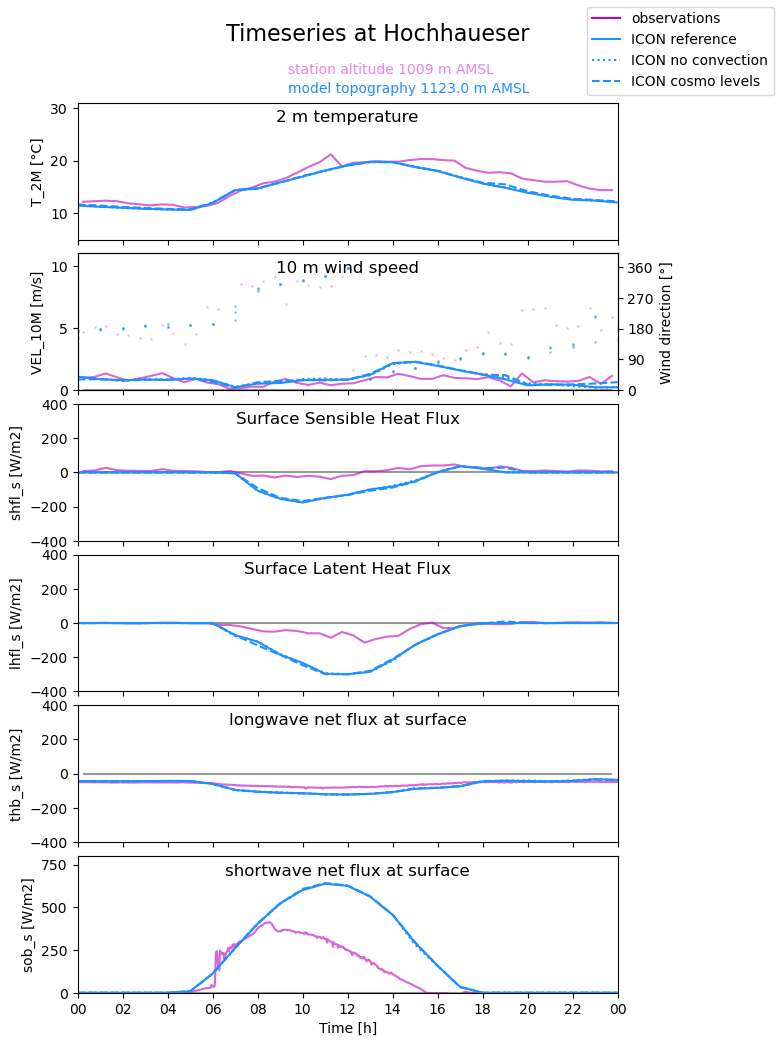

In [69]:
# time range
startdate_plot = dt.datetime(2019,9,13,00,00)
enddate_plot = dt.datetime(2019,9,14,00,00)
plotfreq_plot = '2h0min'
plotdates_plot = pd.date_range(startdate_plot,enddate_plot,freq=plotfreq_plot)

# figure settings
fig, ax = plt.subplots(len(spvars_list),1, figsize=(8,10))
plt.subplots_adjust(bottom=0.01, right=0.8, top=0.9,hspace=0.1)
fig.suptitle('Timeseries at '+loc.name, fontsize=16)
ax[0].annotate('station altitude '+str(loc.alt)+' m AMSL', xy=(0.42,1.17),xytext=(0.39,1.21),xycoords=('axes fraction','axes fraction'),color='violet')
ax[0].annotate('model topography '+str(loc.iconHSURF.round())+' m AMSL', xy=(0.42,0.82),xytext=(0.39,1.07),xycoords=('axes fraction','axes fraction'),color='dodgerblue')
for ax_ts,spvar in zip(ax.flatten(),spvars_list):
        # OBS
        handle_obs = Line2D([0], [0], color='m',linestyle='solid')
        if spvar.name in ts_data_stat_raw.columns:
                ax_ts.plot(ts_data_stat_raw['dt'],np.transpose(ts_data_stat_raw[spvar.name]),color='m',alpha=0.6, label='observations')
        elif spvar.name in ts_data_stat_rad.columns:
                ax_ts.plot(ts_data_stat_rad['dt'],np.transpose(ts_data_stat_rad[spvar.name]),color='m',alpha=0.6, label='observations')
        elif spvar.name in ts_data_stat_flux.columns:
                ax_ts.plot(ts_data_stat_flux['dt'],np.transpose(ts_data_stat_flux[spvar.name]),color='m',alpha=0.6, label='observations')
        # ICON 
        # ax_ts.plot(plotdates_model,ts_data_icon[spvar.name],color='dodgerblue',label='ICON')
        plotdates_model = pd.date_range(startdate_plot,enddate_plot,freq='1h')
        # plotdates_model = ts_data_icon_RUN2.time
        handle_I2 = Line2D([0], [0], color='dodgerblue',linestyle='solid')
        handle_I3 = Line2D([0], [0], color='dodgerblue',linestyle='dotted')
        handle_I4 = Line2D([0], [0], color='dodgerblue',linestyle='dashed')
        # ax_ts.plot(ts_data_icon_RUN1.time,ts_data_icon_RUN1.TKE,color='gray',label='ICON old')
        ax_ts.plot(ts_data_icon_RUN2.time,ts_data_icon_RUN2[spvar.name],color='dodgerblue',label='ICON reference')
        ax_ts.plot(ts_data_icon_RUN3.time,ts_data_icon_RUN3[spvar.name],color='dodgerblue',linestyle = 'dotted', label='ICON no convection')
        ax_ts.plot(ts_data_icon_RUN4.time,ts_data_icon_RUN4[spvar.name],color='dodgerblue',linestyle = 'dashed',label='ICON cosmo levels')

        # plotting options
        ax_ts.set_ylim(spvar.min,spvar.max)
        ax_ts.set_xlim(startdate_plot,enddate_plot)
        # ax_ts.grid()
        ax_ts.set_title(spvar.title, y=1.0, pad=-14)
        ax_ts.set_xlabel('Time [h]')
        ax_ts.set_xticks(plotdates_plot)
        ax_ts.set_xticklabels([])
        ax_ts.set_ylabel(spvar.name+' '+spvar.units)
        ax_ts.hlines(y=0, xmin=ts_data_stat_raw['dt'][0],xmax=ts_data_stat_raw['dt'][-1],colors='k',alpha=0.4)
        # ax_ts.annotate('(obs at '+str(loc.hdict[spvar.name])+' m AGL)', xy=(0.40,0.92),xytext=(0.39,0.92),xycoords=('axes fraction','axes fraction'),color='violet')

        ##################################################################################################
        # ## DIR if VEL is plotted ##
        if spvar.name == 'VEL_10M':
                # plot
                ax_ts_2 = ax_ts.twinx()
                # obs
                ax_ts_2.scatter(ts_data_stat_raw['dt'],np.transpose(ts_data_stat_raw['DIR_10M']),color='violet',alpha=0.4,s=1) # station obs
                # model
                ax_ts_2.scatter(ts_data_icon_RUN2.time,ts_data_icon_RUN2['DIR_10M'],color='dodgerblue',alpha=0.4,s=1)
                ax_ts_2.scatter(ts_data_icon_RUN3.time,ts_data_icon_RUN3['DIR_10M'],color='dodgerblue',alpha=0.4,s=1)
                ax_ts_2.scatter(ts_data_icon_RUN4.time,ts_data_icon_RUN4['DIR_10M'],color='dodgerblue',alpha=0.4,s=1)

                # plotting options
                ax_ts_2.set_ylim(0,400)
                ax_ts_2.set_yticks(np.arange(0,365,90))
                ax_ts_2.set_ylabel('Wind direction [°]')
                ax_ts_2.set_xlim(startdate_plot,enddate_plot)
                ax_ts_2.set_xticks(plotdates_plot)
                ax_ts_2.set_xticklabels([])

legend_handles=[handle_obs,handle_I2,handle_I3, handle_I4]
legend_labels=['observations','ICON reference','ICON no convection','ICON cosmo levels']
fig.legend(legend_handles,legend_labels)
ax[-1].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])

In [70]:
## CALCULATE TOTAL SEB ##
SW_obs = ts_data_stat_rad['sob_s'].resample('H').interpolate('cubic')[1:24]
LW_obs = ts_data_stat_rad['thb_s'].resample('H').interpolate('cubic')[1:24]
SH_obs = ts_data_stat_flux['shfl_s'].resample('min').bfill().resample('H').interpolate('cubic')[1:]
LH_obs = ts_data_stat_flux['lhfl_s'].resample('min').bfill().resample('H').interpolate('cubic')[1:]
T_obs = ts_data_stat_raw['T_2M'].resample('min').bfill().resample('H').interpolate('cubic')[1:]
SEB_obs = SW_obs + LW_obs + SH_obs + LH_obs
SEB_obs
SEB_model = ts_data_icon_RUN2['sob_s'] + ts_data_icon_RUN2['thb_s'] + ts_data_icon_RUN2['shfl_s'] + ts_data_icon_RUN2['lhfl_s']

In [71]:
LH_obs

rawdate
2019-09-13 01:00:00     1.1818
2019-09-13 02:00:00    -2.2376
2019-09-13 03:00:00     0.2998
2019-09-13 04:00:00     1.9329
2019-09-13 05:00:00    -2.0737
2019-09-13 06:00:00   -10.8248
2019-09-13 07:00:00   -19.6744
2019-09-13 08:00:00   -48.6993
2019-09-13 09:00:00   -41.4303
2019-09-13 10:00:00   -60.3213
2019-09-13 11:00:00   -86.2599
2019-09-13 12:00:00    -71.972
2019-09-13 13:00:00   -93.3282
2019-09-13 14:00:00   -74.9798
2019-09-13 15:00:00    -6.7958
2019-09-13 16:00:00   -29.4465
2019-09-13 17:00:00   -13.3079
2019-09-13 18:00:00    -4.8805
2019-09-13 19:00:00    -5.7391
2019-09-13 20:00:00     6.0752
2019-09-13 21:00:00    -0.0339
2019-09-13 22:00:00     4.2203
2019-09-13 23:00:00     3.9462
Freq: H, Name: lhfl_s, dtype: object

In [72]:
hfbl_tendencies = xarray.open_mfdataset('/users/tlezuo/icon-vis/data/data_hfbl/sumbl_ts_data_RUN3_noconv.nc')
hfbl_tendencies=hfbl_tendencies.sel(ncells=loc.subsetID)
TEND_sum = hfbl_tendencies.ddt_temp_clcov + hfbl_tendencies.ddt_temp_drag + hfbl_tendencies.ddt_temp_pconv + hfbl_tendencies.ddt_temp_radlw + hfbl_tendencies.ddt_temp_radsw + hfbl_tendencies.ddt_temp_turb + hfbl_tendencies.ddt_temp_dyn
T2M_change_model = [ts_data_icon_RUN2.T_2M[i].values -  ts_data_icon_RUN2.T_2M[i-1].values for i in range (1,25)]
TL80_change_model = [ts_data_icon_RUN2.T[i][-1].values - ts_data_icon_RUN2.T[i-1][-1].values for i in range (1,25)]
# T_change_obs = np.zeros(2)
T_change_obs = [T_obs[i] - T_obs[i-1] for i in range (1,23)]

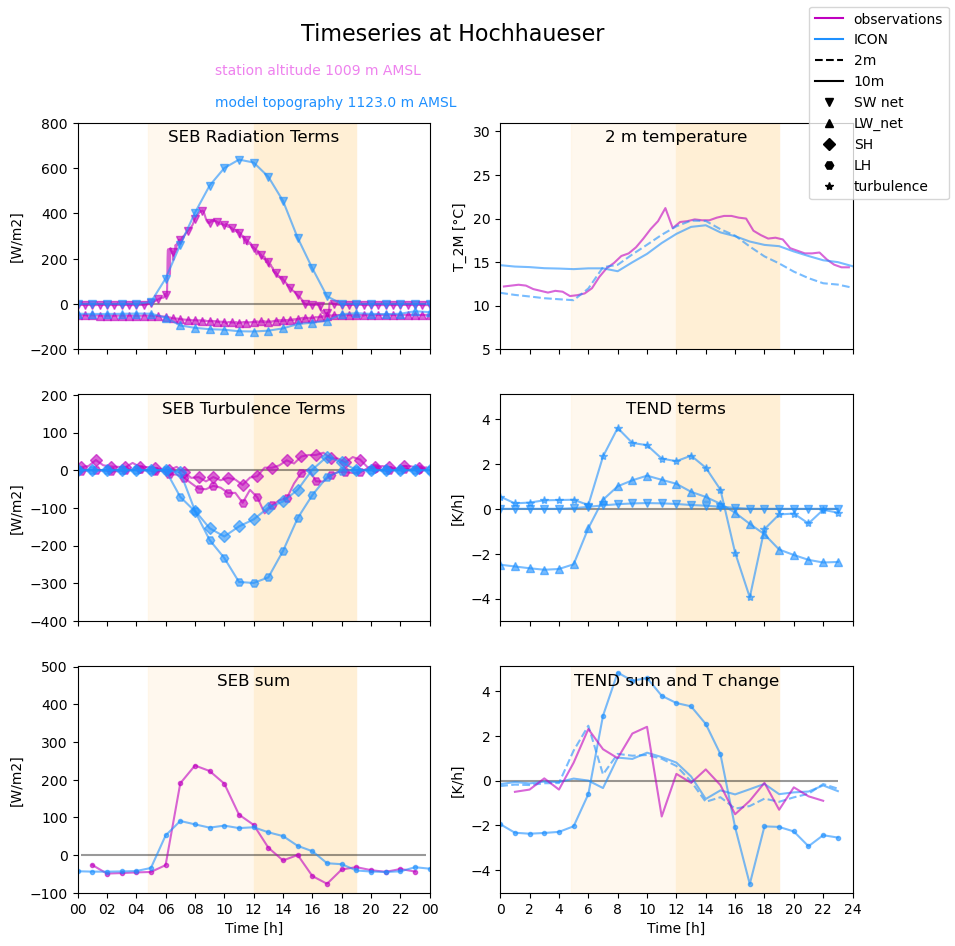

In [73]:
######################################## COMBINED SEB ############################################
pvar_ax1 = vf.T_2M
# time range
startdate_plot = dt.datetime(2019,9,13,00,00)
enddate_plot = dt.datetime(2019,9,14,00,00)
plotfreq_plot = '2h0min'
plotdates_plot = pd.date_range(startdate_plot,enddate_plot,freq=plotfreq_plot)

# figure settings
fig, ax = plt.subplots(3,2, figsize=(10,10))
fig.suptitle('Timeseries at '+loc.name, fontsize=16)
ax[0,0].annotate('station altitude '+str(loc.alt)+' m AMSL', xy=(0.42,1.17),xytext=(0.39,1.21),xycoords=('axes fraction','axes fraction'),color='violet')
ax[0,0].annotate('model topography '+str(loc.iconHSURF.round())+' m AMSL', xy=(0.42,0.82),xytext=(0.39,1.07),xycoords=('axes fraction','axes fraction'),color='dodgerblue')

# OBS
handle_obs = Line2D([0], [0], color='m',linestyle='solid')
ax[0,1].plot(ts_data_stat_raw['dt'],np.transpose(ts_data_stat_raw[pvar_ax1.name]),color='m',alpha=0.6, label='observations')
ax[0,0].plot(ts_data_stat_rad['dt'],np.transpose(ts_data_stat_rad['sob_s']),color='m',alpha=0.6, marker="v",markevery=30)
ax[0,0].plot(ts_data_stat_rad['dt'],np.transpose(ts_data_stat_rad['thb_s']),color='m',alpha=0.6, marker="^",markevery=30)      
ax[1,0].plot(ts_data_stat_flux['dt'],np.transpose(ts_data_stat_flux['shfl_s']),color='m',alpha=0.6, marker="D",markevery=2,)
ax[1,0].plot(ts_data_stat_flux['dt'],np.transpose(ts_data_stat_flux['lhfl_s']),color='m',alpha=0.6, marker="H",markevery=2,)#markerfacecolor='None',linestyle = 'None')
ax[2,0].plot(SEB_obs,color='m',alpha=0.6,marker=".")

# ICON 
plotdates_model = pd.date_range(startdate_plot,enddate_plot,freq='1h')
# plotdates_model = ts_data_icon_RUN2.time
handle_I = Line2D([0], [0], color='dodgerblue',linestyle='solid')

ax[0,1].plot(ts_data_icon_RUN2.time,ts_data_icon_RUN2[pvar_ax1.name],color='dodgerblue',alpha=0.6, linestyle = 'dashed')
ax[0,1].plot(ts_data_icon_RUN2.time,ts_data_icon_RUN2['T'][:,-1].values-273.15,color='dodgerblue',alpha=0.6, linestyle = 'solid')
ax[0,0].plot(ts_data_icon_RUN2.time,ts_data_icon_RUN2['sob_s'],color='dodgerblue',alpha=0.6, marker="v")
ax[0,0].plot(ts_data_icon_RUN2.time,ts_data_icon_RUN2['thb_s'],color='dodgerblue',alpha=0.6, marker="^")       
ax[1,0].plot(ts_data_icon_RUN2.time,ts_data_icon_RUN2['shfl_s'],color='dodgerblue',alpha=0.6, marker="D",)
ax[1,0].plot(ts_data_icon_RUN2.time,ts_data_icon_RUN2['lhfl_s'],color='dodgerblue',alpha=0.6, marker="H",)
ax[2,0].plot(ts_data_icon_RUN2.time,SEB_model,color='dodgerblue',alpha=0.6,marker=".")

# TENDENCIES
# ax4.plot(hfbl_tendencies.ddt_temp_clcov, color='r',alpha=0.6, marker=".",linestyle = 'None',markerfacecolor='None',label='condensation')
# ax4.plot(hfbl_tendencies.ddt_temp_drag, color='dodgerblue',alpha=0.6, marker=".",linestyle = 'None',markerfacecolor='None',label='drag')
# ax4.plot(hfbl_tendencies.ddt_temp_pconv,color='dodgerblue',alpha=0.6, marker="1",linestyle = 'None',markerfacecolor='None',label='convection')
# ax4.plot(hfbl_tendencies.ddt_temp_radlw, color='dodgerblue',alpha=0.6, marker="^",linestyle = 'None',markerfacecolor='None',label='LW')
# ax4.plot(hfbl_tendencies.ddt_temp_radsw, color='dodgerblue',alpha=0.6, marker="v",linestyle = 'None',markerfacecolor='None',label='SW')
# ax4.plot(hfbl_tendencies.ddt_temp_turb, color='dodgerblue',alpha=0.6, marker="*",linestyle = 'None',markerfacecolor='None',label='turbulence')
# ax4.plot(hfbl_tendencies.ddt_temp_dyn, color='dodgerblue',alpha=0.6, marker="o",linestyle = 'None',markerfacecolor='None',label='advection')
ax[1,1].plot(hfbl_tendencies.hour, hfbl_tendencies.ddt_temp_radlw, color='dodgerblue',alpha=0.6, marker="^",label='LW')
ax[1,1].plot(hfbl_tendencies.hour, hfbl_tendencies.ddt_temp_radsw, color='dodgerblue',alpha=0.6, marker="v",label='SW')
ax[1,1].plot(hfbl_tendencies.hour, hfbl_tendencies.ddt_temp_turb, color='dodgerblue',alpha=0.6, marker="*",label='turbulence')
# ax4.scatter(hfbl_tendencies.ddt_temp_dyn, color='dodgerblue',alpha=0.6, marker="o",label='advection')

ax[2,1].plot(hfbl_tendencies.hour, TEND_sum, color='dodgerblue',alpha=0.6, label = 'TEND sum',marker=".")
ax[2,1].plot(hfbl_tendencies.hour, T2M_change_model, color='dodgerblue',alpha=0.6,linestyle = 'dashed', label = 'T2M change')
ax[2,1].plot(hfbl_tendencies.hour, TL80_change_model, color='dodgerblue',alpha=0.6,linestyle = 'solid', label = 'TL80 change')
ax[2,1].plot(np.arange(1,23,1), T_change_obs, color='m',alpha=0.6,linestyle = 'solid', label = 'Tobs change')
# ax[2,1].legend(loc='lower right')

# plotting options T
ax[0,1].set_ylim(pvar_ax1.min,pvar_ax1.max)
ax[0,1].set_title(pvar_ax1.title, y=1.0, pad=-14)
ax[0,1].set_ylabel(pvar_ax1.name+' '+pvar_ax1.units)

ax[0,1].set_xlim(startdate_plot,enddate_plot)
ax[0,1].set_xticks(plotdates_plot)
ax[0,1].set_xticklabels([])
ax[0,1].hlines(y=0, xmin=ts_data_stat_raw['dt'][0],xmax=ts_data_stat_raw['dt'][-1],colors='k',alpha=0.4)

# plotting options SEB Rad
ax[0,0].set_ylim(-200,801)
ax[0,0].set_title('SEB Radiation Terms', y=1.0, pad=-14)
ax[0,0].set_ylabel('[W/m2]')

ax[0,0].set_xlim(startdate_plot,enddate_plot)
ax[0,0].set_xticks(plotdates_plot)
ax[0,0].set_xticklabels([])
ax[0,0].hlines(y=0, xmin=ts_data_stat_raw['dt'][0],xmax=ts_data_stat_raw['dt'][-1],colors='k',alpha=0.4)

# plotting options SEB Turb
ax[1,0].set_ylim(-400,201)
ax[1,0].set_title('SEB Turbulence Terms', y=1.0, pad=-14)
ax[1,0].set_ylabel('[W/m2]')

ax[1,0].set_xlim(startdate_plot,enddate_plot)
ax[1,0].set_xticks(plotdates_plot)
ax[1,0].set_xticklabels([])
ax[1,0].hlines(y=0, xmin=ts_data_stat_raw['dt'][0],xmax=ts_data_stat_raw['dt'][-1],colors='k',alpha=0.4)

# plotting options SEb sum
ax[2,0].set_ylim(-100,501)
ax[2,0].set_title('SEB sum', y=1.0, pad=-14)
ax[2,0].set_ylabel('[W/m2]')

ax[2,0].set_xlim(startdate_plot,enddate_plot)
ax[2,0].set_xticks(plotdates_plot)
# ax[2,0].set_xticklabels([])
ax[2,0].hlines(y=0, xmin=ts_data_stat_raw['dt'][0],xmax=ts_data_stat_raw['dt'][-1],colors='k',alpha=0.4)
ax[2,0].set_xlabel('Time [h]')
ax[2,0].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])

# plotting options TEND terms
ax[1,1].set_ylim(-5,5.1)
ax[1,1].set_title('TEND terms', y=1.0, pad=-14)
ax[1,1].set_ylabel('[K/h]')

ax[1,1].set_xlim(hfbl_tendencies['hour'][0],hfbl_tendencies['hour'][-1]+1)
ax[1,1].set_xticks(np.arange(0,25,2))
ax[1,1].set_xticklabels([])
ax[1,1].hlines(y=0, xmin=hfbl_tendencies['hour'][0],xmax=hfbl_tendencies['hour'][-1],colors='k',alpha=0.4)

# plotting options TENS sum
ax[2,1].set_ylim(-5,5.1)
ax[2,1].set_title('TEND sum and T change', y=1.0, pad=-14)
ax[2,1].set_ylabel('[K/h]')

ax[2,1].set_xlabel('Time [h]')
ax[2,1].set_xlim(hfbl_tendencies['hour'][0],hfbl_tendencies['hour'][-1]+1)
ax[2,1].set_xticks(np.arange(0,25,2))
# ax[2,1].set_xticklabels([])
ax[2,1].hlines(y=0, xmin=hfbl_tendencies['hour'][0],xmax=hfbl_tendencies['hour'][-1],colors='k',alpha=0.4)

# LEGEND
handle_2M = Line2D([0], [0], color='k', linestyle = 'dashed')
handle_L81 = Line2D([0], [0], color='k', linestyle = 'solid')
handle_SW = Line2D([0], [0], color='k', marker="v",linestyle = 'None')
handle_LW = Line2D([0], [0], color='k', marker="^",linestyle = 'None')
handle_SH = Line2D([0], [0], color='k', marker="D",linestyle = 'None')
handle_LH = Line2D([0], [0], color='k', marker="H",linestyle = 'None')
handle_turb = Line2D([0], [0], color='k', marker="*",linestyle = 'None')
legend_handles=[handle_obs,handle_I,handle_2M,handle_L81,handle_SW, handle_LW,handle_SH,handle_LH, handle_turb]
legend_labels=['observations','ICON','2m','10m','SW net','LW_net','SH','LH', 'turbulence']
fig.legend(legend_handles,legend_labels,loc='upper right')

# SUNRISE SUNSET
ax[0,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4)
ax[1,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4)
ax[2,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4)
ax[0,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,dt.datetime(2019,9,13,4,48)),np.full(400,dt.datetime(2019,9,13,17,30)),color='papayawhip',alpha=0.4)
ax[1,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,4.8),np.full(400,17.5),color='papayawhip',alpha=0.4)
ax[2,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,4.8),np.full(400,17.5),color='papayawhip',alpha=0.4)

# VW period
if loc.short == 'kols':
    vw_start = dt.datetime(2019,9,13,12,0)
    vw_s_int = 12
    vw_end = dt.datetime(2019,9,13,18,30)
    vw_e_int = 18.5
elif loc.short == 'weer':
    vw_start = dt.datetime(2019,9,13,12,0)
    vw_s_int = 12
    vw_end = dt.datetime(2019,9,13,16,30)
    vw_e_int = 16.5
elif loc.short == 'hoch':
    vw_start = dt.datetime(2019,9,13,12,0)
    vw_s_int = 12
    vw_end = dt.datetime(2019,9,13,19,0)
    vw_e_int = 19

ax[0,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip')
ax[1,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip')
ax[2,0].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip')
ax[0,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_start),np.full(400,vw_end),color='papayawhip')
ax[1,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_s_int),np.full(400,vw_e_int),color='papayawhip')
ax[2,1].fill_betweenx(np.arange(-4000,4000,20),np.full(400,vw_s_int),np.full(400,vw_e_int),color='papayawhip')

In [74]:
loc.short

'hoch'